Naive PRS implementation with PheWAS/GWAS data

In [1]:
import pandas as pd
import math
import vcf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
confounder=pd.read_csv("../Clinical_Data/AETIO_DIGPD_clinical_final.csv")
con_ids=confounder["AETID"].tolist()
#
vcf_reader = vcf.Reader(filename='../Aetionomy/AETIO_CS_postimpvcf_liftedover_hg38_riskonly.vcf.recode.vcf')
#vcf_reader_oldsnps= vcf.Reader(filename='../Aetionomy/riskSNPs_onlyOldMapping.vcf.recode.vcf')
vcf_ids = list(vcf_reader.samples) 
#
chol=pd.read_csv("../Aetionomy/cholesterolData_AETIONOMYPD.tsv", sep="\t")
chol_ids=chol.index.values.tolist()
##
ids_intersections = [x for x in chol_ids if x in vcf_ids and x in con_ids] # the ids we're using
len(ids_intersections) #106

106

In [3]:
phewas=pd.read_csv("phewascatalog_full.csv", delimiter = ',')
phewas

,chromosome,snp,phewas phenotype,cases,p-value,odds-ratio,gene_name,phewas code,gwas-associations
0,19 45395619,rs2075650,Alzheimer's disease,737,5.237000e-28,2.4100,TOMM40,290.11,"Alzheimer's disease, Alzheimer's disease bioma..."
1,19 45395619,rs2075650,Dementias,1170,2.409000e-26,2.1140,TOMM40,290.10,"Alzheimer's disease, Alzheimer's disease bioma..."
2,6 396321,rs12203592,Actinic keratosis,2505,4.141000e-26,1.6910,IRF4,702.10,"Eye color, Hair color, Freckling, Progressive ..."
3,6 26093141,rs1800562,Iron metabolism disorder,40,3.409000e-25,12.2700,HFE,275.10,"Mean corpuscular hemoglobin, Glycated hemoglob..."
4,19 45395619,rs2075650,Delirium dementia and amnestic disorders,1566,8.027000e-24,1.8410,TOMM40,290.00,"Alzheimer's disease, Alzheimer's disease bioma..."
...,...,...,...,...,...,...,...,...,...
215102,17 7417663,rs6761,"Infertility, male",38,5.000000e-02,0.5945,POLR2A,609.10,Sex hormone binding globulin
215103,3 156626091,rs12638253,Fibroadenosis of breast,26,5.000000e-02,0.5560,LEKR1,610.20,Multiple sclerosis
215104,18,rs7504990,"Inflammatory disease of cervix, vagina, and vulva",660,5.000000e-02,0.8708,DCC,614.50,Gallbladder cancer
215105,19,rs732505,Chronic liver disease and cirrhosis,377,5.000000e-02,1.2920,SAFB2,571.00,Willebrand factor levels


First wrapper function

In [9]:
def prs(snps,csv,log=False,p_threshold=5.000000e-02):
    
    """ Function that takes the snps list + csv as input and filters the csv by the given genes and "Parkinson's disease" phenotype.
        Optional is a p-value threshold (default=0.05) that dismisses all entries larger than the set threshold 
        and summation either over the Log(OR) or OR.
        Returns naive polygenetic risk score (prs) as simple summation of odds ratios / log odds ratios (OR)
    """
    
    assert type(snps)==list
    assert type(csv)==str
    
    catalog=pd.read_csv(csv, delimiter = ',') #reading in the whole csv as a dataframe
    pat = '|'.join(r"{}".format(x) for x in snps) #compile search pattern for input snps of interest
    catalog_filtered = catalog[catalog["snp"].str.contains(pat,na=False)] #filtered catalog containing snps of interest only
    #print (catalog_filtered)
    #print()
    pd_only_series=catalog_filtered["gwas-associations"]=="Parkinson's disease" #filter catalog on pd phenotype only
    catalog_filtered_pd=catalog_filtered[pd_only_series]
    catalog_filtered_pd_pvalue_series=catalog_filtered_pd["p-value"]<p_threshold
    catalog_filtered_pd_pvalue=catalog_filtered_pd[catalog_filtered_pd_pvalue_series]
    
    print (catalog_filtered_pd_pvalue)
    
    odds_ratios=catalog_filtered_pd_pvalue["odds-ratio"].tolist() #calculation of odds_ratios 
    sum_of_odds=sum(odds_ratios)
    print (odds_ratios)
    if sum_of_odds!=0.0:
        if log==True:
            log_odds_ratios=np.log10(odds_ratios)
            return sum(log_odds_ratios)
        else:
            return sum(odds_ratios)
    else:
        return sum(odds_ratios)
    
#testng the function 
genes_2=["rs6088792","rs2274432"]
prs(genes_2,"phewascatalog_full.csv",log=True)

       chromosome        snp     phewas phenotype  cases   p-value  \
2569  20 33909784  rs6088792  Parkinson's disease    252  0.000453   
7886  1 184020945  rs2274432  Parkinson's disease    252  0.001636   

      odds-ratio gene_name  phewas code gwas-associations  
2569       1.401      UQCC        332.0            Height  
7886       1.339    TSEN15        332.0            Height  
[1.401, 1.339]


0.2732187122977836

In [19]:
prs(["rs6088792","rs2274432"],"phewascatalog_full.csv",log=True,p_threshold=0.008) #testingg

       chromosome        snp     phewas phenotype  cases   p-value  \
2569  20 33909784  rs6088792  Parkinson's disease    252  0.000453   
7886  1 184020945  rs2274432  Parkinson's disease    252  0.001636   

      odds-ratio gene_name  phewas code gwas-associations  
2569       1.401      UQCC        332.0            Height  
7886       1.339    TSEN15        332.0            Height  
[1.401, 1.339]


0.2732187122977836

In [44]:
# define PD dataframe beforehand bro

catalog=pd.read_csv("phewascatalog_full.csv", delimiter = ',') #reading in the whole csv as a dataframe

pd_only_series=catalog["phewas phenotype"]=="Parkinson's disease" #filter catalog on pd phenotype only
catalog_filtered_pd=catalog[pd_only_series]

def prs_fast(snps,df,log=False):
    
    """ Function that takes the snps list + df as input and filters the df by the snps.
        Returns naive polygenetic risk score (prs) as simple summation of odds ratios / log odds ratios (OR)
    """
    
    assert type(snps)==list
    
    pat = '|'.join(r"{}".format(x) for x in snps) #compile search pattern for input snps of interest
    catalog_filtered = df[df["snp"].str.contains(pat,na=False)] #filtered catalog containing snps of interest only

    odds_ratios=catalog_filtered["odds-ratio"].tolist() #calculation of odds_ratios 
    sum_of_odds=sum(odds_ratios)
    #print (odds_ratios)
    if sum_of_odds!=0.0:
        if log==True:
            log_odds_ratios=np.log10(odds_ratios)
            return sum(log_odds_ratios)
        else:
            return sum(odds_ratios)
    else:
        return sum(odds_ratios)

In [22]:
prs_fast(["rs6088792","rs2274432"],catalog_filtered_pd,log=True)

0.2732187122977836

In [4]:
# get genotype from our samples and risk snps
vcf_reader = vcf.Reader(filename="../Aetionomy/AETIO_CS_postimpvcf_liftedover_hg38_riskonly.vcf.recode.vcf")
Patient2SnpGenotype={x:{} for x in ids_intersections}
for record in vcf_reader:
    ID=record.ID
    #print (ID)
    for sample in record.samples:
        if sample.sample in ids_intersections:
            #encoding
            if sample["GT"]=='1|1':
                genotype=2
            #    
            if sample["GT"]=='0|0':
                genotype=0
            #    
            if sample["GT"]=='1|0' or sample["GT"]=='0|1' :
                genotype=1
            #    
        
            Patient2SnpGenotype[sample.sample][ID]=genotype

In [5]:
Patient2SnpGenotype

{'AET0044': {'rs12063142': 1,
  'rs12069733': 2,
  'rs1547467': 1,
  'rs7537946': 1,
  'rs4926619': 1,
  'rs7555099': 1,
  'rs6588502': 1,
  'rs4492560': 1,
  'rs10788972': 1,
  'rs12044517': 1,
  'rs11206283': 1,
  'rs11206510': 0,
  'rs7545967': 0,
  'rs112709603': 0,
  'rs78516836': 0,
  'rs72926921': 0,
  'rs59331703': 0,
  'rs72926926': 0,
  'rs7527187': 0,
  'rs72926930': 0,
  'rs11209286': 0,
  'rs12097660': 0,
  'rs12092448': 0,
  'rs11209288': 0,
  'rs12062852': 0,
  'rs11209290': 0,
  'rs12062894': 0,
  'rs12058272': 0,
  'rs113423381': 0,
  'rs6576878': 0,
  'rs11165344': 0,
  'rs1414896': 0,
  'rs4146667': 0,
  'rs10874910': 0,
  'rs2879308': 2,
  'rs1826315': 2,
  'rs1826316': 2,
  'rs2101633': 2,
  'rs10874490': 2,
  'rs1907570': 2,
  'rs2338971': 2,
  'rs17026322': 0,
  'rs12061304': 0,
  'rs61141161': 0,
  'rs35464892': 0,
  'rs12067710': 0,
  'rs12066673': 0,
  'rs12067027': 0,
  'rs11102149': 0,
  'rs12085135': 0,
  'rs7521998': 0,
  'rs7532634': 0,
  'rs7532734': 0,


In [25]:
############## run final ################

# define PD dataframe beforehand 
catalog=pd.read_csv("phewascatalog_full.csv", delimiter = ',') #reading in the whole csv as a dataframe
pd_only_series=catalog["phewas phenotype"]=="Parkinson's disease" #filter catalog on pd phenotype only
catalog_filtered_pd=catalog[pd_only_series]
#
#get the dictionary: Patient -> Mechanisms -> prs's 
Patient2Mechanism2RiskScore=dict()
for pat_ in Patient2Mechs.keys():
    print (pat_)
    Patient2Mechanism2RiskScore[pat_]={}
    for mech_ in Patient2Mechs[pat_].keys():
        #print (mech_)
        for rs in Patient2Mechs[pat_][mech_]:
            score_array=[]
            score=prs_fast([rs],catalog_filtered_pd,log=True)*Patient2SnpGenotype[pat_][rs]
            score_array.append(score)
            Patient2Mechanism2RiskScore[pat_][mech_]=sum(score_array)

AET0044
AET0380
AET0027
AET0049
AET0006
AET0065
AET0374
AET0002
AET0110
AET0372
AET0036
AET0004
AET0070
AET0031
AET0076
AET0078
AET0068
AET0056
AET0055
AET0404
AET0073
AET0075
AET0085
AET0041
AET0025
AET0099
AET0377
AET0045
AET0080
AET0097
AET0090
AET0001
AET0066
AET0062
AET0052
AET0087
AET0022
AET0121
AET0039
AET0415
AET0046
AET0048
AET0051
AET0034
AET0016
AET0077
AET0015
AET0032
AET0418
AET0104
AET0397
AET0137
AET0123
AET0081
AET0107
AET0373
AET0017
AET0114
AET0003
AET0014
AET0074
AET0387
AET0088
AET0115
AET0033
AET0420
AET0030
AET0100
AET0026
AET0029
AET0057
AET0371
AET0122
AET0084
AET0092
AET0064
AET0058
AET0018
AET0103
AET0394
AET0416
AET0011
AET0023
AET0047
AET0109
AET0050
AET0393
AET0106
AET0061
AET0096
AET0028
AET0089
AET0008
AET0043
AET0083
AET0042
AET0035
AET0024
AET0113
AET0093
AET0396
AET0021
AET0071
AET0138
AET0111
AET0390


In [26]:
Patient2Mechanism2RiskScore 

{'AET0044': {'Calcium-dependent signal transduction': 0,
  'Innate immune system subgraph': 0,
  'Cholesterol metabolism subgraph': 0,
  'Vitamin subgraph': 0,
  'GSK3 subgraph': 0,
  'ATP13A2 subgraph': 0,
  'LRRK2 subgraph': 0,
  'Ubiquitin subgraph': 0.20965680730731073,
  'Lipid metabolism subgraph': 0,
  'Mitophagy subgraph': 0,
  'Autophagy signaling subgraph': 0,
  'Dopaminergic subgraph': 0,
  'Transcription subgraph': 0,
  'Mitochondrial subgraph': 0,
  'Interleukin signaling subgraph': 0.0,
  'Reactive oxygen species subgraph': 0,
  'Unfolded protein response subgraph': 0,
  'Cytokine signaling subgraph': 0,
  'Neurotrophic subgraph': 0,
  'Tau protein subgraph': 0,
  'MAPK subgraph': 0,
  'Chaperone subgraph': 0,
  'Cell cycle subgraph': 0,
  'Apoptosis signaling subgraph': 0,
  'Endoplasmic reticulum-Golgi protein export': 0,
  'Phosphatidylinositol 3 subgraph': 0,
  'Bcl-2 subgraph': 0,
  'CRH subgraph': 0,
  'DNA synthesis': 0,
  'Synuclein subgraph': 0,
  'Disaccharide m

In [2]:
##################################################################################

In [10]:
# the best PR Sice result load it
prsice_df=pd.read_csv("../PRSice/PRSice.best",sep=" ")
prsice_df=prsice_df.drop(["IID","In_Regression"],axis=1)
prsice_df=prsice_df.rename(columns={"FID":"AETID"})
prsice_df=prsice_df.set_index("AETID",inplace=False)
prsice_df

,PRS
AETID,
AET0044,-0.006762
AET0380,-0.002260
AET0027,-0.002623
AET0049,-0.001118
AET0006,-0.001417
...,...
AET0021,-0.003441
AET0071,-0.004975
AET0138,-0.001936


In [44]:
#load the PD outcome
outcome=pd.read_csv("../PRSice/phenotype.csv",sep="\t")
outcome=outcome.set_index("AETID",inplace=False)
outcome

,Group_IPD
AETID,
AET0044,0
AET0380,0
AET0027,0
AET0049,1
AET0006,1
...,...
AET0021,0
AET0071,1
AET0138,1


In [45]:
#merge outcome and prs
prsice_pd = pd.concat([prsice_df,outcome], axis=1, sort=False)
prsice_pd

,PRS,Group_IPD
AETID,,
AET0044,-0.006762,0
AET0380,-0.002260,0
AET0027,-0.002623,0
AET0049,-0.001118,1
AET0006,-0.001417,1
...,...,...
AET0021,-0.003441,0
AET0071,-0.004975,1
AET0138,-0.001936,1


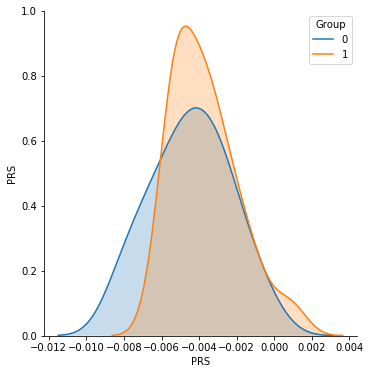

In [46]:
#plot 
prs_plot=sns.pairplot(prsice_pd[["PRS","Group_IPD"]],height=5, hue="Group_IPD")
prs_plot._legend.remove()
plt.legend(title='Group')

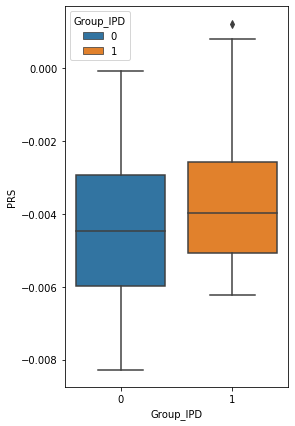

In [47]:
fig, ax = plt.subplots(figsize=(4,7))
sns.boxplot(data=prsice_pd,y="PRS",x="Group_IPD",dodge=False,hue="Group_IPD")

In [48]:
# ks test compare distributions
from scipy import stats

In [49]:
prs_control = prsice_pd.loc[prsice_pd['Group_IPD'] == 0]
prs_sick =  prsice_pd.loc[prsice_pd['Group_IPD'] == 1]

In [55]:
ks_prs=stats.ks_2samp(prs_control["PRS"],prs_sick["PRS"])
ks_prs #no significant difference

Ks_2sampResult(statistic=0.24799081515499427, pvalue=0.07832126197025913)

In [ ]:
#Make dataframe ready

In [34]:
outcomes=pd.read_csv("../Cholesterol_Data/ANOVA_relevantChols_quantilenormed.csv",sep="\t")
outcomes=outcomes.rename(columns={"Unnamed: 0":"AETID"})
outcomes=outcomes.set_index("AETID",inplace=False)
#
confounder=pd.read_csv("../Clinical_Data/Counfounder6_scaled_input_intercept_headers.csv")
confounder=confounder.set_index("AETID",inplace=False)
confounder=confounder.drop(["intercept"],axis=1)
#
#data = pd.concat([outcomes,prsice_df,confounder], axis=1, sort=False)
#data

In [57]:
data.to_csv("../Input_for_Models/Input_MANCOVA/chols_PRsicePRS_confs.csv",header=True,index=True)

In [2]:
####################################################################################

In [11]:
pca=pd.read_csv("../PRSice/cholesterol_targets/AETIO.PCA.csv")
pca=pca.drop("Unnamed: 0",axis=1)
pca=pca.rename(columns={"ind":"AETID"})
pca=pca.set_index("AETID",inplace=False)
pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,spp,loc,spp_loc,spp.1,loc.1,spp_loc.1
AETID,,,,,,,,,,,,,,,,,,,,,
AET0044,-0.005620,0.000360,0.000661,0.001224,0.012327,0.964074,0.213052,0.001875,-0.005723,0.059341,...,0.014641,0.007048,0.014592,0.001737,NaN,NaN,NA_NA,NaN,NaN,NA_NA
AET0380,-0.014153,0.001055,0.014408,0.014997,-0.014409,-0.018239,0.002582,0.005844,-0.007942,0.004415,...,-0.002700,0.015205,-0.000705,0.013965,NaN,NaN,NA_NA,NaN,NaN,NA_NA
AET0027,-0.014188,0.000928,0.015903,0.009762,-0.008287,-0.005793,0.017162,0.017667,-0.003881,0.014873,...,0.042215,0.021661,-0.049941,-0.070580,NaN,NaN,NA_NA,NaN,NaN,NA_NA
AET0049,-0.013608,0.001420,0.010861,0.014039,-0.013832,-0.003069,0.001854,0.008970,-0.019002,0.002077,...,0.012304,0.006026,0.021111,0.011579,NaN,NaN,NA_NA,NaN,NaN,NA_NA
AET0006,-0.015037,0.001640,0.011460,0.017489,-0.009831,-0.030741,0.008010,-0.001624,0.002584,0.020682,...,0.043976,-0.415282,0.198184,0.002450,NaN,NaN,NA_NA,NaN,NaN,NA_NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AET0021,-0.014448,0.001192,0.014562,0.022625,-0.020524,-0.024978,0.032554,0.002385,-0.019263,0.036579,...,-0.022883,0.021208,0.005229,-0.175420,NaN,NaN,NA_NA,NaN,NaN,NA_NA
AET0071,-0.014428,0.000650,0.020130,0.015755,-0.016882,-0.023200,0.023265,0.018903,-0.016221,0.041178,...,-0.047640,0.114773,-0.225430,0.298249,NaN,NaN,NA_NA,NaN,NaN,NA_NA
AET0138,-0.013838,0.001173,0.012612,0.010306,-0.006574,-0.004517,0.010402,0.000798,-0.005139,0.019016,...,0.002314,-0.019678,-0.015869,-0.017523,NaN,NaN,NA_NA,NaN,NaN,NA_NA


In [12]:
#confounder=confounder.drop("Group_IPD",axis=1)

In [13]:
covariates_file = pd.concat([confounder,pca[["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"]]], axis=1, sort=False)

In [14]:
covariates_file['FID'] = covariates_file.index

In [15]:
covariates_file["IID"]=covariates_file["FID"]

In [16]:
covariates_file

,Age,Smoking,Alcohol,Sex,Levodopa,Group_IPD,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,FID,IID
AETID,,,,,,,,,,,,,,,,,,
AET0044,0.062505,0.0,2.0,1,0,0,-0.005620,0.000360,0.000661,0.001224,0.012327,0.964074,0.213052,0.001875,-0.005723,0.059341,AET0044,AET0044
AET0380,0.890703,1.0,1.0,0,1,0,-0.014153,0.001055,0.014408,0.014997,-0.014409,-0.018239,0.002582,0.005844,-0.007942,0.004415,AET0380,AET0380
AET0027,-2.185458,0.0,1.0,1,0,0,-0.014188,0.000928,0.015903,0.009762,-0.008287,-0.005793,0.017162,0.017667,-0.003881,0.014873,AET0027,AET0027
AET0049,1.009017,0.0,2.0,1,0,1,-0.013608,0.001420,0.010861,0.014039,-0.013832,-0.003069,0.001854,0.008970,-0.019002,0.002077,AET0049,AET0049
AET0006,0.890703,1.0,2.0,0,1,1,-0.015037,0.001640,0.011460,0.017489,-0.009831,-0.030741,0.008010,-0.001624,0.002584,0.020682,AET0006,AET0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AET0021,-0.292436,1.0,2.0,1,0,0,-0.014448,0.001192,0.014562,0.022625,-0.020524,-0.024978,0.032554,0.002385,-0.019263,0.036579,AET0021,AET0021
AET0071,0.417447,0.0,3.0,0,0,1,-0.014428,0.000650,0.020130,0.015755,-0.016882,-0.023200,0.023265,0.018903,-0.016221,0.041178,AET0071,AET0071
AET0138,0.417447,0.0,2.0,1,0,1,-0.013838,0.001173,0.012612,0.010306,-0.006574,-0.004517,0.010402,0.000798,-0.005139,0.019016,AET0138,AET0138


In [17]:
mid = covariates_file["FID"]
covariates_file.drop(labels=['FID'], axis=1,inplace = True)
covariates_file.insert(0, 'FID', mid)

In [18]:
mid = covariates_file["IID"]
covariates_file.drop(labels=['IID'], axis=1,inplace = True)
covariates_file.insert(1, 'IID', mid)

In [19]:
covariates_file

,FID,IID,Age,Smoking,Alcohol,Sex,Levodopa,Group_IPD,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
AETID,,,,,,,,,,,,,,,,,,
AET0044,AET0044,AET0044,0.062505,0.0,2.0,1,0,0,-0.005620,0.000360,0.000661,0.001224,0.012327,0.964074,0.213052,0.001875,-0.005723,0.059341
AET0380,AET0380,AET0380,0.890703,1.0,1.0,0,1,0,-0.014153,0.001055,0.014408,0.014997,-0.014409,-0.018239,0.002582,0.005844,-0.007942,0.004415
AET0027,AET0027,AET0027,-2.185458,0.0,1.0,1,0,0,-0.014188,0.000928,0.015903,0.009762,-0.008287,-0.005793,0.017162,0.017667,-0.003881,0.014873
AET0049,AET0049,AET0049,1.009017,0.0,2.0,1,0,1,-0.013608,0.001420,0.010861,0.014039,-0.013832,-0.003069,0.001854,0.008970,-0.019002,0.002077
AET0006,AET0006,AET0006,0.890703,1.0,2.0,0,1,1,-0.015037,0.001640,0.011460,0.017489,-0.009831,-0.030741,0.008010,-0.001624,0.002584,0.020682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AET0021,AET0021,AET0021,-0.292436,1.0,2.0,1,0,0,-0.014448,0.001192,0.014562,0.022625,-0.020524,-0.024978,0.032554,0.002385,-0.019263,0.036579
AET0071,AET0071,AET0071,0.417447,0.0,3.0,0,0,1,-0.014428,0.000650,0.020130,0.015755,-0.016882,-0.023200,0.023265,0.018903,-0.016221,0.041178
AET0138,AET0138,AET0138,0.417447,0.0,2.0,1,0,1,-0.013838,0.001173,0.012612,0.010306,-0.006574,-0.004517,0.010402,0.000798,-0.005139,0.019016


In [21]:
covariates_file_sick = covariates_file.drop(covariates_file[covariates_file.Group_IPD == 0].index)
covariates_file_sick

,FID,IID,Age,Smoking,Alcohol,Sex,Levodopa,Group_IPD,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
AETID,,,,,,,,,,,,,,,,,,
AET0049,AET0049,AET0049,1.009017,0.0,2.0,1,0,1,-0.013608,0.001420,0.010861,0.014039,-0.013832,-0.003069,0.001854,0.008970,-0.019002,0.002077
AET0006,AET0006,AET0006,0.890703,1.0,2.0,0,1,1,-0.015037,0.001640,0.011460,0.017489,-0.009831,-0.030741,0.008010,-0.001624,0.002584,0.020682
AET0065,AET0065,AET0065,0.535761,0.0,2.0,1,0,1,-0.014419,0.001022,0.016593,0.006026,-0.010305,-0.014649,0.026810,-0.003221,-0.005950,0.013160
AET0374,AET0374,AET0374,1.245644,1.0,2.0,0,1,1,-0.012409,0.001249,0.011967,0.003783,-0.005826,-0.015792,0.005253,-0.006914,-0.004075,-0.014164
AET0002,AET0002,AET0002,0.654075,0.0,2.0,0,1,1,-0.014644,0.000871,0.013924,0.012632,-0.015072,-0.035182,0.010940,0.002504,-0.043201,0.028012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AET0043,AET0043,AET0043,-0.884006,1.0,2.0,0,0,1,-0.013315,0.001040,0.010717,0.003364,-0.009803,-0.002918,-0.006182,0.004698,0.014766,-0.016388
AET0093,AET0093,AET0093,-0.765692,1.0,4.0,0,0,1,-0.014820,0.001433,0.007591,0.015737,-0.014743,-0.017078,0.028441,0.022843,-0.017283,0.013236
AET0396,AET0396,AET0396,-0.647378,0.0,4.0,0,0,1,-0.014079,0.001709,0.011933,0.012233,-0.009924,-0.018733,0.006341,0.006866,0.012226,-0.004132


In [22]:
covariates_file_control = covariates_file.drop(covariates_file[covariates_file.Group_IPD == 1].index)
covariates_file_control

,FID,IID,Age,Smoking,Alcohol,Sex,Levodopa,Group_IPD,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
AETID,,,,,,,,,,,,,,,,,,
AET0044,AET0044,AET0044,0.062505,0.0,2.0,1,0,0,-0.005620,0.000360,0.000661,0.001224,0.012327,0.964074,0.213052,0.001875,-0.005723,0.059341
AET0380,AET0380,AET0380,0.890703,1.0,1.0,0,1,0,-0.014153,0.001055,0.014408,0.014997,-0.014409,-0.018239,0.002582,0.005844,-0.007942,0.004415
AET0027,AET0027,AET0027,-2.185458,0.0,1.0,1,0,0,-0.014188,0.000928,0.015903,0.009762,-0.008287,-0.005793,0.017162,0.017667,-0.003881,0.014873
AET0110,AET0110,AET0110,0.180819,1.0,2.0,1,0,0,-0.014563,0.001112,0.010525,0.016728,-0.027103,-0.021761,0.030839,0.009654,-0.008560,0.031499
AET0073,AET0073,AET0073,-1.120633,0.0,2.0,1,0,0,-0.012385,0.001177,0.005540,0.007138,0.001448,0.016114,-0.024947,-0.016207,0.000720,-0.017661
AET0075,AET0075,AET0075,-1.357261,1.0,2.0,0,0,0,-0.014150,0.000721,0.016900,0.014891,-0.003218,-0.014242,0.008397,0.018005,-0.012932,0.019834
AET0041,AET0041,AET0041,-0.174122,1.0,2.0,1,0,0,-0.013379,0.001217,0.010183,0.005569,-0.000589,-0.010851,0.015514,0.008672,0.009767,-0.004983
AET0099,AET0099,AET0099,-1.357261,0.0,2.0,1,0,0,-0.014953,0.001271,0.014766,0.014095,-0.018091,-0.019579,0.049441,0.026063,0.007838,0.064665
AET0377,AET0377,AET0377,1.127330,1.0,5.0,0,0,0,-0.014855,0.001528,0.020447,0.007276,-0.009890,-0.022990,0.017645,0.007113,-0.011316,0.005964


In [55]:
covariates_file.to_csv("../PRSice/cholesterol_targets/AETIO.covariates",index=False,header=True,sep=" ")

In [35]:
outcomes.insert(0, 'IID', mid)
outcomes.insert(0, 'FID', mid)

In [36]:
outcomes_withgroup=pd.concat([outcomes,covariates_file["Group_IPD"]], axis=1)
outcomes_withgroup

,FID,IID,Campestanol µg/dl,Campesterol mg/dl,Sitostanol µg/dl,Sitosterol mg/dl,Stigmasterol µg/dl,Group_IPD
AETID,,,,,,,,
AET0044,AET0044,AET0044,41.458895,46.468789,39.662632,44.501789,42.482474,0
AET0380,AET0380,AET0380,67.878579,76.027737,64.537474,65.386895,52.602526,0
AET0027,AET0027,AET0027,44.008684,46.043947,42.802895,47.678211,55.210053,0
AET0049,AET0049,AET0049,61.334053,56.392579,59.671632,56.745526,66.070737,1
AET0006,AET0006,AET0006,34.404368,35.503211,43.591789,41.326737,39.177263,1
...,...,...,...,...,...,...,...,...
AET0021,AET0021,AET0021,31.469053,39.662632,25.072000,31.725579,35.503211,0
AET0071,AET0071,AET0071,35.148421,38.095684,30.366684,36.000789,33.430000,1
AET0138,AET0138,AET0138,36.000789,31.469053,43.286526,34.619421,35.148421,1


In [37]:
outcomes_file_sick = outcomes_withgroup.drop(outcomes_withgroup[outcomes_withgroup.Group_IPD == 0].index)
outcomes_file_control = outcomes_withgroup.drop(outcomes_withgroup[outcomes_withgroup.Group_IPD == 1].index)

In [40]:
outcomes_file_sick

,FID,IID,Campestanol µg/dl,Campesterol mg/dl,Sitostanol µg/dl,Sitosterol mg/dl,Stigmasterol µg/dl,Group_IPD
AETID,,,,,,,,
AET0049,AET0049,AET0049,61.334053,56.392579,59.671632,56.745526,66.070737,1
AET0006,AET0006,AET0006,34.404368,35.503211,43.591789,41.326737,39.177263,1
AET0065,AET0065,AET0065,55.210053,47.913737,52.392526,52.392526,50.270526,1
AET0374,AET0374,AET0374,41.326737,36.567421,47.299947,42.802895,39.951632,1
AET0002,AET0002,AET0002,31.168053,41.458895,32.689895,43.591789,38.095684,1
...,...,...,...,...,...,...,...,...
AET0043,AET0043,AET0043,38.349158,48.785632,34.619421,46.973789,46.973789,1
AET0093,AET0093,AET0093,49.803000,46.848474,47.678211,51.290105,39.662632,1
AET0396,AET0396,AET0396,36.765737,43.706579,35.828737,41.855947,51.578105,1


In [39]:
outcomes_file_sick[["IID","FID","Campestanol µg/dl"]].to_csv("../PRSice/cholesterol_targets/Campestanol_sick.csv",index=False,header=True,sep=" ")
outcomes_file_control[["IID","FID","Campestanol µg/dl"]].to_csv("../PRSice/cholesterol_targets/Campestanol_control.csv",index=False,header=True,sep=" ")

In [68]:
outcomes[["IID","FID","Campestanol µg/dl"]].to_csv("../PRSice/cholesterol_targets/Campestanol.csv",index=False,header=True,sep=" ")

outcomes[["IID","FID","Campesterol mg/dl"]].to_csv("../PRSice/cholesterol_targets/Campesterol.csv",index=False,header=True,sep=" ")

outcomes[["IID","FID","Sitostanol µg/dl"]].to_csv("../PRSice/cholesterol_targets/Sitostanol.csv",index=False,header=True,sep=" ")

outcomes[["IID","FID","Sitosterol mg/dl"]].to_csv("../PRSice/cholesterol_targets/Sitosterol.csv",index=False,header=True,sep=" ")

outcomes[["IID","FID","Stigmasterol µg/dl"]].to_csv("../PRSice/cholesterol_targets/Stigmasterol.csv",index=False,header=True,sep=" ")